In [2]:
import pandas
import numpy as np
import matplotlib.pyplot as plt
from nltk import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix, roc_curve, auc
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split, StratifiedShuffleSplit
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import random
import pylab as pl
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem import PorterStemmer
import re

In [3]:
path = 'smsspamcollection/SMSSpamCollection'

messages = pandas.read_csv(path, sep='\t',
                           names=["label", "message"])
messages.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


Проверим, сбалансирован ли датасет.

In [4]:
print(len(messages[messages.label=='ham']), len(messages[messages.label=='spam']))

4825 747


Нет.
Посмотрим на результаты дамми классификатора.

In [71]:
dummyresults = ['ham' for i in range(len(messages))]
'{0:.3f}'.format(accuracy_score(dummyresults, messages.label))

'0.866'

Неплохая аккуратность, но для задачи определения спама не годится.
Разделим выборку и обучим байесовскую модель.

In [72]:
# ham = messages.message[messages.label == 'ham'].values.tolist()
# spam = messages.message[messages.label == 'spam'].values.tolist()
# ham_ti = random.sample(list(range(len(ham))), 600)
# spam_ti = random.sample(list(range(len(spam))), 600)
# ham_test = []
# ham_train = []
# for i in range(len(ham)):
#     if i in ham_ti:
#         ham_train.append(ham[i])
#     else:
#         ham_test.append(ham[i])
# spam_test = []
# spam_train = []
# for i in range(len(spam)):
#     if i in spam_ti:
#         spam_train.append(spam[i])
#     else:
#         spam_test.append(spam[i])
# train = ham_train + spam_train
# test = ham_test + spam_test
# train_answers = ['ham' for i in ham_train] + ['spam' for i in spam_train]
# test_answers = ['ham' for i in ham_test] + ['spam' for i in spam_test]
# print(len(train), len(train_answers), len(test), len(test_answers))

прошу прощения, что я всё переконвертировала в листы, но я потратила 2 (!!!) часа на то чтобы сделать это нормально, перепробовала кучу всего, и ничего не получилось. 

ИСПРАВЛЕНИЕ НИЖЕ

In [73]:
ham = messages.message[messages.label == 'ham']
spam = messages.message[messages.label == 'spam']
hams = ham.sample(n=600)
spams = spam.sample(n=600)
ham_test = [i for i in ham if i not in hams]
spam_test = [i for i in spam if i not in spams]
print(type(hams))
train = pandas.concat([hams, spams])
test = ham_test + spam_test
train_answers = ['ham' for i in hams] + ['spam' for i in spams]
test_answers = ['ham' for i in ham_test] + ['spam' for i in spam_test]
print(train.head())

<class 'pandas.core.series.Series'>
4555    Try to do something dear. You read something f...
2357                          No..he joined today itself.
4276    Haiyoh... Maybe your hamster was jealous of mi...
3150               Sorry,  in meeting I'll call you later
3609                       Pls come quick cant bare this.
Name: message, dtype: object


# Векторизация документов

In [74]:
# bow = CountVectorizer()
# bow.fit_transform(messages['message'])
# bowed_train = bow.transform(train)
# bowed_test = bow.transform(test)
# # print(test[4], bowed_test[4])
# print(type(bowed_train))
# naive_model = MultinomialNB()
# naive_model.fit(bowed_train, np.array(train_answers))

Вот тут, кстати, не очень понятный мне момент. Получается, что в матрице должны оказаться и слова из трайнинг, и слова из тестинг сет, чтобы она была одинковой размерности для них. Как это можно осуществлять, когда модель действительно должна работать на новых данных? Отбрасывать все совсем незнакомые слова? Перестраивать матрицу и переучиваться, встретив каждое новое слово?

ИСПРАВЛЕНИЕ СНИЗУ

In [89]:
bowed_train = bow.fit_transform(train)
 
bowed_test = bow.transform(test)
naive_model = MultinomialNB()
naive_model.fit(bowed_train, np.array(train_answers))


MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [76]:
predicted = naive_model.predict(bowed_test)

print(classification_report(test_answers, predicted))
print(confusion_matrix(test_answers, predicted))

             precision    recall  f1-score   support

        ham       1.00      0.97      0.98      4825
       spam       0.82      0.98      0.89       747

avg / total       0.97      0.97      0.97      5572

[[4664  161]
 [  18  729]]


Получилось даже как-то подорительно хорошо... 
Хотя на спапе точность 0.53, то есть половина того что опонается спамом - и не спам вовсе. То есть совсем не хорошо.

ПОСЛЕ ПРАВИЛЬНОЙ ВЕКТОРИЗАЦИИ ВСЁ СТАЛО РАБОТАТЬ ЛУЧШЕ (МНЕ НЕПОНЯТНО, ПРАВДА, ПОЧЕМУ), НО НА СПАМЕ УЖЕ ТОЧНОСТЬ 83 - ВПОЛНЕ НЕПЛОХО!

# Удалим знаки препинания. 

In [77]:
test_clear = [re.sub('[\.,!\?:;"\']', '', sent) for sent in test]
train_clear = [re.sub('[\.,!\?:;"\']', '', sent) for sent in train]

In [78]:
# bow = CountVectorizer()
# bow.fit_transform([re.sub('[\.,!\?:;"\']', '', sent) for sent in messages['message']])
# bowed_train_clear = bow.transform(train_clear)
# bowed_test_clear = bow.transform(test_clear)
# # print(test[4], bowed_test[4])
# naive_model_clear = MultinomialNB()
# naive_model_clear.fit(bowed_train_clear, np.array(train_answers))

ИСПРАВЛЕНИЕ СНИЗУ

In [90]:
bowed_train_clear = bow.fit_transform(train_clear)
 
bowed_test_clear = bow.transform(test_clear)
naive_model_clear = MultinomialNB()
naive_model_clear.fit(bowed_train_clear, np.array(train_answers))


MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [91]:
predicted_clear = naive_model_clear.predict(bowed_test_clear)

print(classification_report(test_answers, predicted_clear))
print(confusion_matrix(test_answers, predicted_clear))

             precision    recall  f1-score   support

        ham       1.00      0.96      0.98      4825
       spam       0.80      0.97      0.87       747

avg / total       0.97      0.96      0.96      5572

[[4639  186]
 [  22  725]]


Все стало только хуже! Возможно, в спаме больше знаков препинания, чем обычно, мы их отбрасываем и всё портится.

НА САМОМ ДЕЛЕ ПОЧТИ НИЧЕГО НЕ ПОМЕНЯЛОСЬ.

# Попробуем всё лемматизировать перед векторизацией

In [92]:
def tokenize(text):
    text = text.lower()
    return word_tokenize(text)

lmtzr = WordNetLemmatizer()

def lemmatize(word):
    noun = lmtzr.lemmatize(word)
    verb = lmtzr.lemmatize(word, 'v')
    if verb != word:
        return verb
    return noun

def lematize(text):
    text = tokenize(text)
    text = ' '.join([lemmatize(word) for word in text])
    return text

train_lem = [lematize(sent) for sent in train]
test_lem = [lematize(sent) for sent in test]

In [93]:
# bow = CountVectorizer()
# bow.fit_transform([lematize(sent) for sent in messages['message']])
# bowed_train_lem = bow.transform(train_lem)
# bowed_test_lem = bow.transform(test_lem)
# naive_model_lem = MultinomialNB()
# naive_model_lem.fit(bowed_train_lem, np.array(train_answers))
# predicted_lem = naive_model_lem.predict(bowed_test_lem)


ИСПРАВЛЕНИЕ СНИЗУ

In [94]:
bowed_train_lem = bow.fit_transform(train_lem)
 
bowed_test_lem = bow.transform(test_lem)
naive_model_lem = MultinomialNB()
naive_model_lem.fit(bowed_train_lem, np.array(train_answers))


MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [95]:
predicted_lem = naive_model_lem.predict(bowed_test_lem)
print(classification_report(test_answers, predicted_lem))
print(confusion_matrix(test_answers, predicted_lem))

             precision    recall  f1-score   support

        ham       1.00      0.96      0.98      4825
       spam       0.80      0.97      0.88       747

avg / total       0.97      0.96      0.97      5572

[[4648  177]
 [  21  726]]


никакого эффекта :(

# А если всё застемить?

In [96]:
port = PorterStemmer()
def stemize(text):
    text = tokenize(text)
    text = ' '.join([port.stem(word) for word in text])
    return text

train_stem = [stemize(sent) for sent in train]
test_stem = [stemize(sent) for sent in test]

In [97]:
# bow = CountVectorizer()
# bow.fit_transform([stemize(sent) for sent in messages['message']])
# bowed_train_stem = bow.transform(train_stem)
# bowed_test_stem = bow.transform(test_stem)
# naive_model_stem = MultinomialNB()
# naive_model_stem.fit(bowed_train_stem, np.array(train_answers))


ИСПРАВЛЕНИЕ СНИЗУ

In [98]:
bowed_train_stem = bow.fit_transform(train_stem)
 
bowed_test_stem = bow.transform(test_stem)
naive_model_stem = MultinomialNB()
naive_model_stem.fit(bowed_train_stem, np.array(train_answers))


MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [99]:
predicted_stem = naive_model_stem.predict(bowed_test_stem)
print(classification_report(test_answers, predicted_stem))
print(confusion_matrix(test_answers, predicted_stem))

             precision    recall  f1-score   support

        ham       1.00      0.96      0.98      4825
       spam       0.81      0.97      0.88       747

avg / total       0.97      0.97      0.97      5572

[[4653  172]
 [  20  727]]


работает пренебрежимо мало лучше. А на что мы надеялись? В богатом флективном английском и так все слова одинаковые, даже если их не лемматизировать.

# Дерево и лес

Сделаем дерево и лес

In [100]:
tree = DecisionTreeClassifier(min_samples_split=5)
tree.fit(bowed_train, np.array(train_answers))
predicted_tree = tree.predict(bowed_test)

print(classification_report(test_answers, predicted_tree))

             precision    recall  f1-score   support

        ham       1.00      0.95      0.97      4825
       spam       0.75      0.98      0.85       747

avg / total       0.96      0.95      0.96      5572



Дерево работает еще хуже! Оно еще больше сообщений безвинно засовывает в спам!

In [101]:
forest = RandomForestClassifier(min_samples_split=5)
forest.fit(bowed_train, np.array(train_answers))
predicted_forest = forest.predict(bowed_test)

print(classification_report(test_answers, predicted_forest))

             precision    recall  f1-score   support

        ham       1.00      0.97      0.99      4825
       spam       0.86      0.98      0.91       747

avg / total       0.98      0.97      0.98      5572



А вот лес уже больше радует. Но для задачи определения спама хотелось бы видеть бОльшую точность, полнота здесь не так важна. Не так страшно прислать пользователю спам, как удалить нормальное сообщение. А во всех трех моделях точность страдает...

посмотрим рок-кривые

In [102]:
def to10(test_answers):
    test_answers10 = []
    for i in test_answers:
        if i == 'spam':
            test_answers10.append(0)
        else:
            test_answers10.append(1)
    return test_answers10
test_answers10 = to10(test_answers)
predicted10 = to10(predicted)
predicted_tree10 = to10(predicted_tree)
predicted_forest10 = to10(predicted_forest)
predicted_lem10 = to10(predicted_lem)
predicted_stem10 = to10(predicted_stem)
predicted_clear10 = to10(predicted_clear)

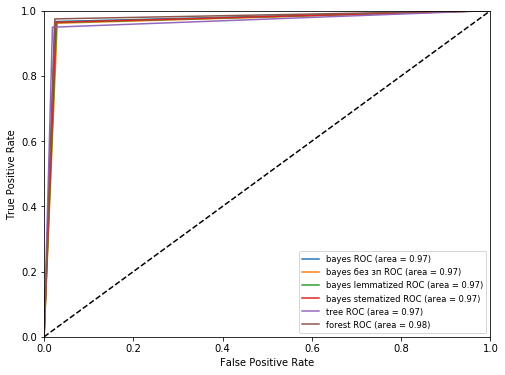

In [103]:
pl.clf()
plt.figure(figsize=(8,6))


fpr, tpr, thresholds = roc_curve(test_answers10, predicted10)
roc_auc  = auc(fpr, tpr)
pl.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % ('bayes', roc_auc))

fpr, tpr, thresholds = roc_curve(test_answers10, predicted_clear10)
roc_auc  = auc(fpr, tpr)
pl.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % ('bayes без зп', roc_auc))

fpr, tpr, thresholds = roc_curve(test_answers10, predicted_lem10)
roc_auc  = auc(fpr, tpr)
pl.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % ('bayes lemmatized', roc_auc))

fpr, tpr, thresholds = roc_curve(test_answers10, predicted_stem10)
roc_auc  = auc(fpr, tpr)
pl.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % ('bayes stematized', roc_auc))

fpr, tpr, thresholds = roc_curve(test_answers10, predicted_tree10)
roc_auc  = auc(fpr, tpr)
pl.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % ('tree', roc_auc))


fpr, tpr, thresholds = roc_curve(test_answers10, predicted_forest10)
roc_auc  = auc(fpr, tpr)
pl.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % ('forest', roc_auc))


pl.plot([0, 1], [0, 1], 'k--')
pl.xlim([0.0, 1.0])
pl.ylim([0.0, 1.0])
pl.xlabel('False Positive Rate')
pl.ylabel('True Positive Rate')
pl.legend(loc=0, fontsize='small')
pl.show()

Честно говоря, не знаю, что тут сказать... Всё плохо, но лес чуть лучше, а дерево - чуть хуже.